In [22]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.0+cu116
Torchvision Version:  0.13.0+cu116


In [23]:
def makedir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)

In [24]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "C:\ex\hands\gesture\kaggleandjisaku"

model_path = "C:\ex\sen\\finetuning\\runs\\train\gesture7\model_weights.pth"
# data_dir = "C:\ex\sen\data\max_square\\train_val"
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"
#結果出力ディレクトリ
output_name = "kaggle_model_jisaku_val"
# Number of classes in the dataset
num_classes = 7
# Batch size for training (change depending on how much memory you have)
batch_size = 1
feature_extract = False

output_base_dir = "runs\\val"
out_dir = os.path.join(output_base_dir,output_name)
if os.path.exists(out_dir):
  print("出力ディレクトリ名が被っているよ")
  sys.exit()

makedir(out_dir)

In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
from efficientnet_pytorch import EfficientNet
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "efficientnetb0":
        model_ft = EfficientNet.from_pretrained('efficientnet-b0')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        model_ft._fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "efficientnetb6":
        model_ft = EfficientNet.from_pretrained('efficientnet-b6')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        model_ft._fc = nn.Linear(num_ftrs, num_classes)
        input_size = 528
    
    elif model_name == "efficientnetb7":
        model_ft = EfficientNet.from_pretrained('efficientnet-b7')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        model_ft._fc = nn.Linear(num_ftrs, num_classes)
        input_size = 600
    elif model_name == "efficientnetv2s":
        model_ft = EfficientNet.from_pretrained('efficientnet-b7')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        model_ft._fc = nn.Linear(num_ftrs, num_classes)
        input_size = 480
    elif model_name == "efficientnetv2m":
        model_ft = EfficientNet.from_pretrained('efficientnet-b7')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        model_ft._fc = nn.Linear(num_ftrs, num_classes)
        input_size = 480

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [27]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        # transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['val']}
class_names = image_datasets['val'].classes
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.load_state_dict(torch.load(model_path))
model_ft = model_ft.to(device)

Initializing Datasets and Dataloaders...


In [28]:

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [29]:
from PIL import Image

def tensor_to_np(inp):
    "imshow for Tesor"
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def false_img_save(pred, label, input, false_img_count):
    pil_img = Image.fromarray(input)
    makedir(out_dir + 'error/pred_' + str(class_names[pred.item()]) + '_label_' + str(class_names[label.item()]))
    pil_img.save(out_dir + f'error/pred_{class_names[pred.item()]}_label_{class_names[label.item()]}/{false_img_count}.jpg')

[[[0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  ...
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]]

 [[0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  ...
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]]

 [[0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  ...
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.74181366e-09]]

 ...

 [[0.00000000e+00 3.05175781e-08 2.74181366e-09]
  [0.00000000e+00 3.05175781e-08 2.7418

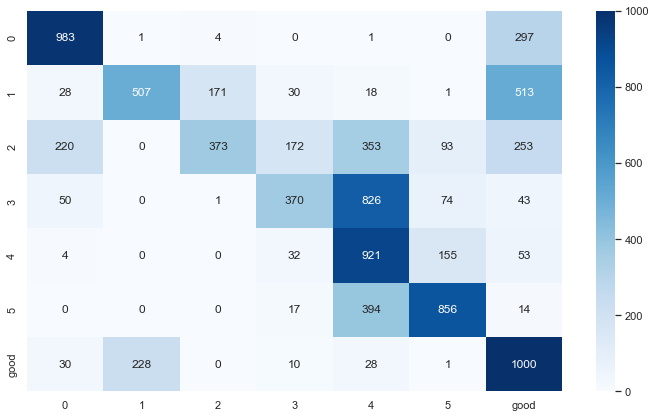

In [30]:
import pandas as pd
import seaborn as sn

def val_model(model, dataloaders, optimizer):
    false_img_count = 0
    phase = 'val'
    confusion_matrix = torch.zeros(num_classes, num_classes)
    model.eval()
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            #######################################################
            for i in range(inputs.size()[0]):
                if preds[i] != labels[i]:
                    input = tensor_to_np(inputs.cpu().data[i])
                    print(input)
                    input *= 255
                    input = input.astype(np.uint8)
                    
                    false_img_save(preds[i], labels[i], input, false_img_count)
                    false_img_count += 1

            #######################################################

            for t_confusion_matrix, p_confusion_matrix in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t_confusion_matrix.long(), p_confusion_matrix.long()] += 1
    
    confusion_matrix_numpy = confusion_matrix.to('cpu').detach().numpy().copy()
    df_cmx = pd.DataFrame(confusion_matrix_numpy, index=class_names, columns=class_names)
    plt.figure(figsize = (12, 7))
    sn.set(font_scale = 1)
    sn.heatmap(df_cmx, annot=True, fmt='g', cmap='Blues')
    plt.savefig(os.path.join(out_dir,"confusion_matrix.png"))
    sn.set(font_scale = 1)

val_model(model_ft, dataloaders_dict, optimizer_ft)